# **Q2**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# run this cell for plotting
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''

    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

Implement this function for changing phases and amplitudes of images.

In [16]:
def draw_phase_amplitude(image):
    '''
    Returns the phase image and the amplitude image from the input image.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        tuple of numpy.ndarray: The tuple of the phase image and the amplitude image.
    '''

    phase = image.copy()
    amp = image.copy()
    img = image.copy()

    # convert image to floats and do dft saving as complex output
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

    # apply shift of origin from upper left corner to center of image
    dft_shift = np.fft.fftshift(dft)

    # extract magnitude and phase images
    mag, phase = cv2.cartToPolar(dft_shift[:,:,0], dft_shift[:,:,1])

    magnitude_spectrum = 20*np.log(mag)

    return phase, magnitude_spectrum

def change_phase_domain(image1, image2):
    '''
    Substitutes the phase of image1 by the phase of image2 and returns two new images.

    Parameters:
        image1 (numpy.ndarray): The input image1.
        image2 (numpy.ndarray): The input image2.

    Returns:
        tuple of numpy.ndarray: The tuple of result images.
    '''

    img1 = image1.copy()
    img2 = image2.copy()

    pha1, amp1 = draw_phase_amplitude(img1)
    pha2, amp2 = draw_phase_amplitude(img2)

    amp1 = np.exp(amp1/20)
    amp2 = np.exp(amp2/20)

    # convert magnitude and phase into cartesian real and imaginary components
    real1, imag1 = cv2.polarToCart(amp1, pha2)
    real2, imag2 = cv2.polarToCart(amp2, pha1)

    # combine cartesian components into one complex image
    back1 = cv2.merge([real1, imag1])
    back2 = cv2.merge([real2, imag2])

    # shift origin from center to upper left corner
    back_ishift_1 = np.fft.ifftshift(back1)
    back_ishift_2 = np.fft.ifftshift(back2)

    # do idft saving as complex output
    img_back_1 = cv2.idft(back_ishift_1)
    img_back_2 = cv2.idft(back_ishift_2)

    # combine complex components into original image again
    out1 = cv2.magnitude(img_back_1[:,:,0], img_back_1[:,:,1])
    out2 = cv2.magnitude(img_back_2[:,:,0], img_back_2[:,:,1])

    # Normalize back to 8bit
    min, max = np.amin(img_back_1, (0,1)), np.amax(img_back_1, (0,1))
    out1 = cv2.normalize(out1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    min, max = np.amin(img_back_2, (0,1)), np.amax(img_back_2, (0,1))
    out2 = cv2.normalize(out2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return out1, out2

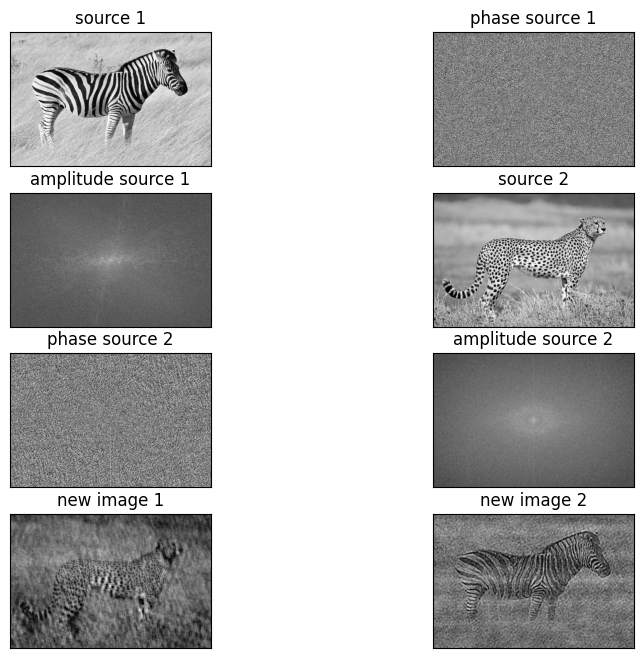

In [17]:
# dont change this cell
image_list = []
image1 = cv2.imread(os.path.join('images', '1.jpg'), cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(os.path.join('images', '2.jpg'), cv2.IMREAD_GRAYSCALE)

image_list.append([image1, 'source 1', 'img'])

phase1, amp1 = draw_phase_amplitude(image1)
image_list.append([phase1, 'phase source 1', 'img'])
image_list.append([amp1, 'amplitude source 1', 'img'])

image_list.append([image2, 'source 2', 'img'])

phase2, amp2 = draw_phase_amplitude(image2)
image_list.append([phase2, 'phase source 2', 'img'])
image_list.append([amp2, 'amplitude source 2', 'img'])

res1, res2 = change_phase_domain(image1, image2)
image_list.append([res1, 'new image 1', 'img'])
image_list.append([res2, 'new image 2', 'img'])

plotter(image_list, 4, 2, True, 10, 8, 'Q3')